<a href="https://colab.research.google.com/github/smx789963/Multi-DFSIB/blob/main/widar_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/data')

Mounted at /content/drive


In [ ]:
#read single view data

import os
import numpy as np
import scipy.io as scio

# Directories for data loading and saving
data_dir = ['DFS/20181117/user4', 'DFS/20181118/user2', 'DFS/20181118/user3']
model_dir = 'DFS/big-single-data'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define file paths for saving the data
data_file = os.path.join(model_dir, 'data_receiver_1.npy')
label_file = os.path.join(model_dir, 'label_receiver_1.npy')

def normalize_data(data):
    """Normalize data to the range [0, 1]."""
    data_max = np.concatenate((data.max(axis=0), data.max(axis=1)), axis=0).max(axis=0)
    data_min = np.concatenate((data.min(axis=0), data.min(axis=1)), axis=0).min(axis=0)
    if np.any((data_max - data_min) == 0):
        return data
    data_max_rep = np.tile(data_max, (data.shape[0], data.shape[1], 1))
    data_min_rep = np.tile(data_min, (data.shape[0], data.shape[1], 1))
    data_norm = (data - data_min_rep) / (data_max_rep - data_min_rep)
    return data_norm

def zero_padding(data, max_length):
    """Apply zero padding to the data to ensure consistent length."""
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        if t > 0:
            data_pad.append(np.pad(data[i], ((0,0),(0,0),(max_length - t,0)), 'constant', constant_values=0).tolist())
    return np.array(data_pad)

def load_data_and_labels(data_dir, batch_size=5):
    """Load data and labels from the specified directory and apply necessary preprocessing."""
    all_data = []
    all_labels = []
    T_MAX = 0

    if not os.path.exists(data_dir):
        raise ValueError(f"The specified path {data_dir} does not exist")

    all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]

    # Find the maximum length of data to determine padding
    for file_path in all_files:
        try:
            mat_data = scio.loadmat(file_path)
            data = mat_data['doppler_spectrum']
            current_length = data.shape[2]
            if T_MAX < current_length:
                T_MAX = current_length
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

    # Load data in batches
    for i in range(0, len(all_files), batch_size):
        batch_files = all_files[i:i+batch_size]
        data_batch = []
        labels_batch = []
        for file_path in batch_files:
            try:
                mat_data = scio.loadmat(file_path)
                data = mat_data['doppler_spectrum']

                # Check data dimensions
                if data.ndim != 3:
                    print(f"Skipping file {file_path} due to unexpected data dimensions: {data.ndim}")
                    continue

                # Extract label from file name
                file_name = os.path.basename(file_path)
                label = int(file_name.split('-')[1])
                print(f"Processing file: {file_path}, Label: {label}")

                # Normalize the data
                data_normed = normalize_data(data)

                # Select data from receiver 1
                selected_data = data_normed[0:1, :, :]  # Select data from receiver 1

                data_batch.append(selected_data)
                labels_batch.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

        if len(data_batch) > 0:
            data_batch = zero_padding(data_batch, T_MAX)
            data_batch = np.array(data_batch)  # [N, 1, 121, T_MAX]
            data_batch = np.transpose(data_batch, (0, 3, 2, 1))   # [N, T_MAX, 121, 1]
            all_data.append(data_batch)
            all_labels.append(np.array(labels_batch))

    if all_data:
        all_data = np.concatenate(all_data, axis=0)
    else:
        all_data = np.array([])
    if all_labels:
        all_labels = np.concatenate(all_labels, axis=0)
    else:
        all_labels = np.array([])

    return all_data, all_labels

# Load data and save it to files
data, labels = load_data_and_labels(data_dir, batch_size=5)
if data.size > 0:
    np.save(data_file, data)
if labels.size > 0:
    np.save(label_file, labels)

print(f"Data and labels have been saved to respective files.")
if data.size > 0:
    print(f"Data shape: {data.shape}")
if labels.size > 0:
    print(f"Label shape: {labels.shape}")
    print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")


In [ ]:
#read multi view data
import os
import numpy as np
import scipy.io as scio

# Define the directories containing the data
data_dirs = ['DFS/20181117/user4', 'DFS/20181118/user2', 'DFS/20181118/user3']
model_dir = 'DFS/big-multi-data'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define file paths for saving data and labels
data_file = os.path.join(model_dir, 'data.npy')
label_file = os.path.join(model_dir, 'label.npy')

def normalize_data(data):
    """Normalize the data to a range of [0, 1]."""
    data_max = np.concatenate((data.max(axis=0), data.max(axis=1)), axis=0).max(axis=0)
    data_min = np.concatenate((data.min(axis=0), data.min(axis=1)), axis=0).min(axis=0)
    if np.any((data_max - data_min) == 0):
        return data
    data_max_rep = np.tile(data_max, (data.shape[0], data.shape[1], 1))
    data_min_rep = np.tile(data_min, (data.shape[0], data.shape[1], 1))
    data_norm = (data - data_min_rep) / (data_max_rep - data_min_rep)
    return data_norm

def zero_padding(data, max_length):
    """Apply zero-padding to the data to ensure consistent length."""
    data_pad = []
    for i in range(len(data)):
        t = np.array(data[i]).shape[2]
        if t > 0:
            data_pad.append(np.pad(data[i], ((0,0),(0,0),(max_length - t,0)), 'constant', constant_values=0).tolist())
    return np.array(data_pad)

def load_data_and_labels(data_dirs, batch_size=5):
    """Load data and labels from the specified directories and apply necessary preprocessing."""
    all_data = []
    all_labels = []
    T_MAX = 0

    # Get the list of all files from the specified directories
    all_files = []
    for data_dir in data_dirs:
        if not os.path.exists(data_dir):
            raise ValueError(f"The specified path {data_dir} does not exist")
        all_files += [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.mat')]

    # Determine the maximum time step length
    for file_path in all_files:
        try:
            mat_data = scio.loadmat(file_path)
            data = mat_data['doppler_spectrum']
            current_length = data.shape[2]
            if T_MAX < current_length:
                T_MAX = current_length
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

    # Load and process the data
    for i in range(0, len(all_files), batch_size):
        batch_files = all_files[i:i+batch_size]
        data_batch = []
        labels_batch = []
        for file_path in batch_files:
            try:
                mat_data = scio.loadmat(file_path)
                data = mat_data['doppler_spectrum']

                # Check the data dimensions
                if data.ndim != 3:
                    print(f"Skipping file {file_path} due to unexpected data dimensions: {data.ndim}")
                    continue

                # Extract the label from the filename
                file_name = os.path.basename(file_path)
                label = int(file_name.split('-')[1])
                print(f"Processing file: {file_path}, Label: {label}")

                # Normalize the data
                data_normed = normalize_data(data)

                # Select data from receivers 1, 3, and 6
                selected_data = data_normed[[0, 2, 5], :, :]  # Select receivers 1, 3, 6

                data_batch.append(selected_data.tolist())
                labels_batch.append(label)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

        if len(data_batch) > 0:
            data_batch = zero_padding(data_batch, T_MAX)
            data_batch = np.array(data_batch)  # [N, 3, 121, T_MAX]
            data_batch = np.transpose(data_batch, (0, 3, 2, 1))  # [N, T_MAX, 121, 3]
            all_data.append(data_batch)
            all_labels.append(np.array(labels_batch))

    if all_data:
        all_data = np.concatenate(all_data, axis=0)
    else:
        all_data = np.array([])
    if all_labels:
        all_labels = np.concatenate(all_labels, axis=0)
    else:
        all_labels = np.array([])

    return all_data, all_labels

# Load data and save it to files
data, labels = load_data_and_labels(data_dirs, batch_size=5)
if data.size > 0:
    np.save(data_file, data)
if labels.size > 0:
    np.save(label_file, labels)

print(f"Data and labels have been saved to respective files.")
if data.size > 0:
    print(f"Data shape: {data.shape}")
if labels.size > 0:
    print(f"Label shape: {labels.shape}")
    print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")


In [ ]:
#single-cnn

import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Directory where data is stored
data_dir = 'DFS/big-single-data'

# Directory to save results
model_dir = 'final/single'

# Ensure the save directory exists
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Load the saved data
data_file = os.path.join(data_dir, 'data_receiver_1.npy')
label_file = os.path.join(data_dir, 'label_receiver_1.npy')
data = np.load(data_file)
labels = np.load(label_file)

# Split the data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Perform One-hot encoding on the labels
N_MOTION = len(np.unique(labels))
labels_train = to_categorical(labels_train - 1, N_MOTION)
labels_test = to_categorical(labels_test - 1, N_MOTION)

# Define the input shape for the model
input_shape = (data.shape[1], data.shape[2], 1)

# Assemble the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_MOTION, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Set up ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Train the model and display accuracy for each epoch
history = model.fit(data_train, labels_train, batch_size=32, epochs=90, validation_split=0.2, verbose=1, callbacks=[reduce_lr])

# Print training and validation accuracy for each epoch
for epoch, acc, val_acc in zip(range(len(history.history['accuracy'])), history.history['accuracy'], history.history['val_accuracy']):
    print(f"Epoch {epoch+1}, Training Accuracy: {acc:.4f}, Validation Accuracy: {val_acc:.4f}")

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(data_test, labels_test)
print('Test accuracy:', test_acc)

# Predict and generate confusion matrix
labels_test_pred = model.predict(data_test)
labels_test_pred = np.argmax(labels_test_pred, axis=-1) + 1
labels_test_true = np.argmax(labels_test, axis=-1) + 1

cm = confusion_matrix(labels_test_true, labels_test_pred)
print(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(cm)

# Save training history
with open(os.path.join(model_dir, 'single_view_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# Save predicted and true labels
np.save(os.path.join(model_dir, 'single_view_labels_test_true.npy'), labels_test_true)
np.save(os.path.join(model_dir, 'single_view_labels_test_pred.npy'), labels_test_pred)

# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Single View Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'single_view_accuracy.png'))
plt.close()

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Single View Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'single_view_loss.png'))
plt.close()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title('Single View Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(model_dir, 'single_view_confusion_matrix.png'))
plt.close()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 2970, 119, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1485, 59, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2803680)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 64)                  │     179,435,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,436,294 (684.50 MB)

 Trainable params: 179,436,294 (684.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - accuracy: 0.2965 - loss: 5.1263 - val_accuracy: 0.3556 - val_loss: 1.4691 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.3499 - loss: 1.5171 - val_accuracy: 0.4025 - val_loss: 1.3828 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3485 - loss: 1.4653 - val_accuracy: 0.4222 - val_loss: 1.2909 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3865 - loss: 1.4020 - val_accuracy: 0.4370 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.3977 - loss: 1.3682 - val_accuracy: 0.4691 - val_loss: 1.2581 - learning_rate: 0.0010
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.4448 - loss: 1.2570 - val_accuracy: 0.4642 - val_loss: 1.2552 - learning_rate: 0.0010
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.4368 - loss: 1.2817 -

ValueError: The layer sequential has never been called and thus has no defined input.

In [ ]:
#multi-cnn

import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Define data directory
model_dir = 'DFS/big-multi-data'
save_dir = 'final/multi'

# Create save directory (if it doesn't exist)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load saved data
data_file = os.path.join(model_dir, 'data.npy')
label_file = os.path.join(model_dir, 'label.npy')
data = np.load(data_file)
labels = np.load(label_file)

# Split the data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Perform One-hot encoding on the labels
N_MOTION = len(np.unique(labels))
labels_train = to_categorical(labels_train - 1, N_MOTION)
labels_test = to_categorical(labels_test - 1, N_MOTION)

# Model input shape
input_shape = (data.shape[1], data.shape[2], 1)

# Define subnetwork for feature extraction
def create_subnetwork(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    return input_layer, x

# Build three subnetworks to process data from three receivers
inputs = []
features = []
for i in range(3):
    input_layer, feature = create_subnetwork(input_shape)
    inputs.append(input_layer)
    features.append(feature)

# Concatenate the outputs of the subnetworks
merged_features = Concatenate()(features)
x = Dense(128, activation='relu')(merged_features)
x = Dropout(0.5)(x)
output_layer = Dense(N_MOTION, activation='softmax')(x)

# Build and compile the model
optimizer = Adam()  # Use default learning rate 0.001
model = Model(inputs=inputs, outputs=output_layer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Prepare training data
train_data = [data_train[:, :, :, i:i+1] for i in range(3)]
test_data = [data_test[:, :, :, i:i+1] for i in range(3)]

# Set up ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Train the model
history = model.fit(train_data, labels_train, batch_size=32, epochs=90, validation_split=0.2, callbacks=[reduce_lr])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, labels_test)
print('Test accuracy:', test_acc)

# Extract features
feature_extractor = Model(inputs=inputs, outputs=features)
train_features = feature_extractor.predict(train_data)
test_features = feature_extractor.predict(test_data)

# Save feature data to final/multi directory
for i in range(3):
    np.save(os.path.join(save_dir, f'train_features_receiver_{i+1}.npy'), train_features[i])
    np.save(os.path.join(save_dir, f'test_features_receiver_{i+1}.npy'), test_features[i])

# Predict and generate confusion matrix
labels_test_pred = model.predict(test_data)
labels_test_pred = np.argmax(labels_test_pred, axis=-1) + 1
labels_test_true = np.argmax(labels_test, axis=-1) + 1

cm = confusion_matrix(labels_test_true, labels_test_pred)
print(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.around(cm, decimals=2)
print(cm)

# Save training history
with open(os.path.join(model_dir, 'multi_view_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

# Save predicted and true labels
np.save(os.path.join(model_dir, 'multi_view_labels_test_true.npy'), labels_test_true)
np.save(os.path.join(model_dir, 'multi_view_labels_test_pred.npy'), labels_test_pred)

# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multi View Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'multi_view_accuracy.png'))
plt.close()

# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Multi View Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_dir, 'multi_view_loss.png'))
plt.close()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title('Multi View Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(model_dir, 'multi_view_confusion_matrix.png'))
plt.close()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 2972, 121, 1)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2972, 121, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 2972, 121, 1)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 2970, 119, 32)  │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 2970, 119, 32)  │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 2970, 119, 32)  │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1485, 59, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 1485, 59, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 1485, 59, 32)   │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2803680)        │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2803680)        │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 2803680)        │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │    179,435,584 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │    179,435,584 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │    179,435,584 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_1[0][0]          │
├──────────────────────

 Total params: 538,333,190 (2.01 GB)

 Trainable params: 538,333,190 (2.01 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 0.2508 - loss: 6.9052 - val_accuracy: 0.4173 - val_loss: 1.5105 - learning_rate: 0.0010
Epoch 2/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3180 - loss: 1.5770 - val_accuracy: 0.4667 - val_loss: 1.3416 - learning_rate: 0.0010
Epoch 3/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.4114 - loss: 1.4200 - val_accuracy: 0.5111 - val_loss: 1.2864 - learning_rate: 0.0010
Epoch 4/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.4298 - loss: 1.3509 - val_accuracy: 0.5309 - val_loss: 1.2413 - learning_rate: 0.0010
Epoch 5/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4522 - loss: 1.3173 - val_accuracy: 0.5309 - val_loss: 1.2088 - learning_rate: 0.0010
Epoch 6/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.4618 - loss: 1.2788 - val_accuracy: 0.5556 - val_loss: 1.1586 - learning_rate: 0.0010
Epoch 7/90
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.5396 - loss: 1.1659 -

In [2]:
#multi-DFSIB

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import argparse
from torch.optim.lr_scheduler import StepLR
import copy
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

class MultiViewDFSIB(nn.Module):
    def __init__(self, input_dim, time_dim, hidden_dim, output_dim, args):
        super(MultiViewDFSIB, self).__init__()

        self.args = args

        # Define feature extraction networks for each view
        self.view1_feature_extraction = nn.Sequential(
            nn.Linear(time_dim * input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.view2_feature_extraction = nn.Sequential(
            nn.Linear(time_dim * input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.view3_feature_extraction = nn.Sequential(
            nn.Linear(time_dim * input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        # Define IB (Information Bottleneck) layers for each view
        self.view1_ib_mu = nn.Sequential(
            nn.Linear(256, 32),
            nn.Tanh()
        )

        self.view2_ib_mu = nn.Sequential(
            nn.Linear(256, 32),
            nn.Tanh()
        )

        self.view3_ib_mu = nn.Sequential(
            nn.Linear(256, 32),
            nn.Tanh()
        )

        self.view1_ib_sigma = nn.Sequential(
            nn.Linear(256, 32),
            nn.Sigmoid()
        )

        self.view2_ib_sigma = nn.Sequential(
            nn.Linear(256, 32),
            nn.Sigmoid()
        )

        self.view3_ib_sigma = nn.Sequential(
            nn.Linear(256, 32),
            nn.Sigmoid()
        )

        # Define encoders for each view
        self.view1_encoder1 = nn.Sequential(
            nn.Linear(32, args['dim1']),
            nn.Sigmoid()
        )

        self.view1_encoder2 = nn.Sequential(
            nn.Linear(32, args['dim2']),
            nn.Sigmoid()
        )

        self.view2_encoder1 = nn.Sequential(
            nn.Linear(32, args['dim1']),
            nn.Sigmoid()
        )

        self.view2_encoder2 = nn.Sequential(
            nn.Linear(32, args['dim2']),
            nn.Sigmoid()
        )

        self.view3_encoder1 = nn.Sequential(
            nn.Linear(32, args['dim1']),
            nn.Sigmoid()
        )

        self.view3_encoder2 = nn.Sequential(
            nn.Linear(32, args['dim2']),
            nn.Sigmoid()
        )

        # Define decoders for each view
        self.view_specific_decoder1 = nn.Sequential(
            nn.Linear(args['dim1'] + args['dim2'], 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        self.view_specific_decoder2 = nn.Sequential(
            nn.Linear(args['dim1'] + args['dim2'], 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        self.view_specific_decoder3 = nn.Sequential(
            nn.Linear(args['dim1'] + args['dim2'], 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        # Define final decoders for combined features
        self.decoder1 = nn.Sequential(
            nn.Linear(3 * args['dim1'], 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

        self.decoder2 = nn.Sequential(
            nn.Linear(3 * (args['dim1'] + args['dim2']), 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def reparameterize(self, mu, sigma):
        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, args):
        feature1, feature2, feature3, KL_loss = self.IB_feature_extraction(x)

        encoded_view1_1 = self.view1_encoder1(feature1)
        encoded_view2_1 = self.view2_encoder1(feature2)
        encoded_view3_1 = self.view3_encoder1(feature3)

        encoded_view1_2 = self.view1_encoder2(feature1)
        encoded_view2_2 = self.view2_encoder2(feature2)
        encoded_view3_2 = self.view3_encoder2(feature3)

        quantized_view1_1 = (torch.round(encoded_view1_1) - encoded_view1_1).detach() + encoded_view1_1 - 0.5
        quantized_view2_1 = (torch.round(encoded_view2_1) - encoded_view2_1).detach() + encoded_view2_1 - 0.5
        quantized_view3_1 = (torch.round(encoded_view3_1) - encoded_view3_1).detach() + encoded_view3_1 - 0.5

        quantized_view1_2 = (torch.round(encoded_view1_2) - encoded_view1_2).detach() + encoded_view1_2 - 0.5
        quantized_view2_2 = (torch.round(encoded_view2_2) - encoded_view2_2).detach() + encoded_view2_2 - 0.5
        quantized_view3_2 = (torch.round(encoded_view3_2) - encoded_view3_2).detach() + encoded_view3_2 - 0.5

        # Save encoded features to the specified directory
        self.save_encoded_features(quantized_view1_1, quantized_view2_1, quantized_view3_1,
                                   quantized_view1_2, quantized_view2_2, quantized_view3_2)

        view_specific_feature1 = torch.cat((quantized_view1_1, quantized_view1_2), dim=1)
        view_specific_feature2 = torch.cat((quantized_view2_1, quantized_view2_2), dim=1)
        view_specific_feature3 = torch.cat((quantized_view3_1, quantized_view3_2), dim=1)

        received_feature_T1 = torch.cat((quantized_view1_1, quantized_view2_1, quantized_view3_1), dim=1)
        received_feature_T2 = torch.cat((view_specific_feature1, view_specific_feature2, view_specific_feature3), dim=1)

        view_specific_output1 = self.view_specific_decoder1(view_specific_feature1)
        view_specific_output2 = self.view_specific_decoder2(view_specific_feature2)
        view_specific_output3 = self.view_specific_decoder3(view_specific_feature3)

        T1_output = self.decoder1(received_feature_T1)
        T2_output = self.decoder2(received_feature_T2)

        return F.log_softmax(T2_output, dim=1), F.log_softmax(T1_output, dim=1), \
               F.log_softmax(view_specific_output1, dim=1), F.log_softmax(view_specific_output2, dim=1), \
               F.log_softmax(view_specific_output3, dim=1), KL_loss

    def IB_feature_extraction(self, x):
        view1 = x[:, 0, :, :].view(-1, 2972 * 121)
        view2 = x[:, 1, :, :].view(-1, 2972 * 121)
        view3 = x[:, 2, :, :].view(-1, 2972 * 121)

        feature_view1 = self.view1_feature_extraction(view1)
        feature_view2 = self.view2_feature_extraction(view2)
        feature_view3 = self.view3_feature_extraction(view3)

        mu1 =  10 * self.view1_ib_mu(feature_view1)
        sigma1 = self.view1_ib_sigma(feature_view1)

        mu2 =  10 * self.view2_ib_mu(feature_view2)
        sigma2 = self.view2_ib_sigma(feature_view2)

        mu3 =  10 * self.view3_ib_mu(feature_view3)
        sigma3 = self.view3_ib_sigma(feature_view3)

        KL_loss = self.KL_loss(mu1, sigma1) + self.KL_loss(mu2, sigma2) + self.KL_loss(mu3, sigma3)

        if self.training:
            feature1 = self.reparameterize(mu1, sigma1)
            feature2 = self.reparameterize(mu2, sigma2)
            feature3 = self.reparameterize(mu3, sigma3)
        else:
            feature1 = mu1
            feature2 = mu2
            feature3 = mu3

        return feature1, feature2, feature3, KL_loss

    def KL_loss(self, mu, sigma, sigma2=1):
        batch_size = mu.size()[0]
        J = mu.size()[1]

        mu_diff = mu ** 2
        var1 = sigma ** 2
        var2 = sigma2 ** 2

        var_frac = var1 / var2
        diff_var_frac = mu_diff / var2

        term1 = torch.sum(torch.log(var_frac)) / batch_size
        term2 = torch.sum(var_frac) / batch_size
        term3 = torch.sum(diff_var_frac) / batch_size

        return -0.5 * (term1 - term2 - term3 + J)

    def IB_extractor_requires_grad(self, requires_grad=False):
        for params in self.view1_feature_extraction.parameters():
            params.requires_grad = requires_grad

        for params in self.view2_feature_extraction.parameters():
            params.requires_grad = requires_grad

        for params in self.view3_feature_extraction.parameters():
            params.requires_grad = requires_grad

        for params in self.view1_ib_mu.parameters():
            params.requires_grad = requires_grad

        for params in self.view2_ib_mu.parameters():
            params.requires_grad = requires_grad

        for params in self.view3_ib_mu.parameters():
            params.requires_grad = requires_grad

        for params in self.view1_ib_sigma.parameters():
            params.requires_grad = requires_grad

        for params in self.view2_ib_sigma.parameters():
            params.requires_grad = requires_grad

        for params in self.view3_ib_sigma.parameters():
            params.requires_grad = requires_grad

    def save_encoded_features(self, view1_1, view2_1, view3_1, view1_2, view2_2, view3_2):
        """Save encoded features"""
        save_dir = 'final/dfsib'  # Save directory
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        np.save(os.path.join(save_dir, 'view1_1.npy'), view1_1.detach().cpu().numpy())
        np.save(os.path.join(save_dir, 'view2_1.npy'), view2_1.detach().cpu().numpy())
        np.save(os.path.join(save_dir, 'view3_1.npy'), view3_1.detach().cpu().numpy())

        np.save(os.path.join(save_dir, 'view1_2.npy'), view1_2.detach().cpu().numpy())
        np.save(os.path.join(save_dir, 'view2_2.npy'), view2_2.detach().cpu().numpy())
        np.save(os.path.join(save_dir, 'view3_2.npy'), view3_2.detach().cpu().numpy())

# The rest of the code remains unchanged

def load_data(data_dir, test_size=0.2):
    import os
    # Load saved data
    data_file = os.path.join(data_dir, 'data.npy')
    label_file = os.path.join(data_dir, 'label.npy')
    data = np.load(data_file)
    labels = np.load(label_file)
    data = data.transpose((0, 3, 1, 2))
    labels -= 1
    # Split the data into training and testing sets
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, random_state=42)

    # Convert labels to integer type
    labels_train = labels_train.astype(int)
    labels_test = labels_test.astype(int)

    return data_train, data_test, labels_train, labels_test

def train_VIB(args, model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, KL_loss = model(data, args)
        loss = F.nll_loss(view_specific_output1, target) + F.nll_loss(view_specific_output2, target) + F.nll_loss(view_specific_output3, target) + 1e-4 * KL_loss  # VIB loss
        loss.backward()
        optimizer.step()
        pred = T2_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(train_loader.dataset)
    return loss, accuracy

def train_dfsib_model(args, model, device, train_loader, optimizer, epoch):
    model.IB_extractor_requires_grad(requires_grad=False)
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, _ = model(data, args)
        loss = F.nll_loss(T2_output, target) + F.nll_loss(T1_output, target) + args['beta'] * (
                    F.nll_loss(view_specific_output1, target) + F.nll_loss(view_specific_output2, target) + F.nll_loss(view_specific_output3, target))
        loss.backward()
        optimizer.step()
        pred = T2_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(train_loader.dataset)
    return loss, accuracy


def fine_tune(args, model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, KL_loss = model(data, args)
        loss = F.nll_loss(T2_output, target) + F.nll_loss(T1_output, target) + args['beta'] * (
                    F.nll_loss(view_specific_output1, target) + F.nll_loss(view_specific_output2, target) + F.nll_loss(view_specific_output3, target)) + 1e-4 * KL_loss  # Fine-tuning loss
        loss.backward()
        optimizer.step()
        pred = T2_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(train_loader.dataset)
    return loss, accuracy


def test_dfsib_model(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct_internal = 0
    labels_test_true = []
    labels_test_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, KL_loss = model(data, args)
            test_loss += F.nll_loss(T2_output, target, reduction='sum').item()
            pred = T2_output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred_internal = T1_output.argmax(dim=1, keepdim=True)
            correct_internal += pred_internal.eq(target.view_as(pred_internal)).sum().item()
            labels_test_true.extend(target.cpu().numpy())
            labels_test_pred.extend(pred.cpu().numpy().flatten())
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    internal_accuracy = 100. * correct_internal / len(test_loader.dataset)
    return test_loss, accuracy, internal_accuracy, labels_test_true, labels_test_pred

def inference(args, model, device, test_loader, threshold):
    model.eval()
    count_one_trans = 0
    all_points = 0
    all_correct_points = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, _ = model(data,args)
            coefficient, _ = torch.max(F.softmax(T2_output, dim=1), dim=1, keepdim=True)
            coefficient = torch.where((coefficient) > (threshold), torch.ones(1).to(device), torch.zeros(1).to(device))
            count_one_trans += torch.norm(coefficient, p=1)
            output_cascade = torch.mul(T2_output, coefficient) + torch.mul(T1_output, (1 - coefficient))
            pred_cascade = output_cascade.argmax(dim=1, keepdim=False)
            results = pred_cascade == target
            correct_points = torch.sum(results.long())
            all_correct_points += correct_points
            all_points += results.size()[0]
        acc = all_correct_points.float() / all_points
        acc = acc.cpu().data.numpy()
        retransmission_ratio = 1 - (count_one_trans.float() / all_points).item()
        communication_cost = 3 * (args['dim1'] * args['bit'] + args['dim2'] * args['bit'] * retransmission_ratio)
        return acc, communication_cost


def save_and_plot(history, model_dir, phase):
    # Save training history
    with open(os.path.join(model_dir, f'{phase}_history.pkl'), 'wb') as f:
        pickle.dump(history, f)

    # Plot training and validation accuracy curves
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{phase} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(model_dir, f'{phase}_accuracy.png'))
    plt.close()

    # Plot training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{phase} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(model_dir, f'{phase}_loss.png'))
    plt.close()

def main():
    # Load data
    data_train, data_test, labels_train, labels_test = load_data('DFS/big-multi-data')

    num_classes = len(np.unique(labels_train))

    train_dataset = TensorDataset(torch.Tensor(data_train), torch.LongTensor(labels_train))
    test_dataset = TensorDataset(torch.Tensor(data_test), torch.LongTensor(labels_test))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Initialize the model and optimizer
    model = MultiViewDFSIB(input_dim=121, time_dim=2972, hidden_dim=128, output_dim=num_classes, args=args).to(device)

    best_internal_acc = 0
    best_model = []
    model_dir = 'final/dfsib'

    # Initialize history records
    pretrain_history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    dvib_history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    fine_tune_history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    # Pretrain the feature extractor
    optimizer1 = optim.SGD(model.parameters(), lr=args['lr'])
    scheduler1 = StepLR(optimizer1, step_size=10, gamma=args['gamma'])
    for epoch in range(0, args['epochs']):  # Pretrain the feature extractor(s)
        train_loss, train_accuracy = train_VIB(args, model, device, train_loader, optimizer1, epoch)
        val_loss, val_accuracy, val_internal_accuracy, _, _ = test_dfsib_model(args, model, device, test_loader)

        # Record history
        pretrain_history['train_loss'].append(train_loss.item())
        pretrain_history['val_loss'].append(val_loss)
        pretrain_history['train_accuracy'].append(train_accuracy)
        pretrain_history['val_accuracy'].append(val_internal_accuracy)

        print('VIB training ... epoch:', epoch, "loss", train_loss.item())
        scheduler1.step()

    save_and_plot(pretrain_history, model_dir, 'pretrain')

    # Train the DFSIB model
    optimizer2 = optim.SGD(model.parameters(), lr=args['lr'])
    scheduler2 = StepLR(optimizer2, step_size=10, gamma=args['gamma'])

    for epoch in range(0, args['epochs']):  # Train the DFSIB
        train_loss, train_accuracy = train_dfsib_model(args, model, device, train_loader, optimizer2, epoch)
        val_loss, val_accuracy, val_internal_accuracy, _, _ = test_dfsib_model(args, model, device, test_loader)

        # Record history
        dvib_history['train_loss'].append(train_loss.item())
        dvib_history['val_loss'].append(val_loss)
        dvib_history['train_accuracy'].append(train_accuracy)
        dvib_history['val_accuracy'].append(val_internal_accuracy)

        print('DFSIB-SR training ... epoch:', epoch, "loss", train_loss.item())
        scheduler2.step()
        if val_internal_accuracy > best_internal_acc:
            best_internal_acc = val_internal_accuracy
            best_model = copy.deepcopy(model.state_dict())

    save_and_plot(dvib_history, model_dir, 'dvib')

    # Fine-tune the model
    optimizer3 = optim.SGD(model.parameters(), lr=args['lr'])
    scheduler3 = StepLR(optimizer3, step_size=10, gamma=args['gamma'])

    for epoch in range(0, args['epochs']):
        train_loss, train_accuracy = fine_tune(args, model, device, train_loader, optimizer3, epoch)
        val_loss, val_accuracy, val_internal_accuracy, _, _ = test_dfsib_model(args, model, device, test_loader)

        # Record history
        fine_tune_history['train_loss'].append(train_loss.item())
        fine_tune_history['val_loss'].append(val_loss)
        fine_tune_history['train_accuracy'].append(train_accuracy)
        fine_tune_history['val_accuracy'].append(val_internal_accuracy)

        print(f'Fine-tuning ... epoch: {epoch}')
        print(f"  Training Loss: {train_loss.item():.6f}")
        print(f"  Training Accuracy: {train_accuracy:.2f}%")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Validation Accuracy: {val_internal_accuracy:.2f}%")

        scheduler3.step()
        if val_internal_accuracy > best_internal_acc:
            best_internal_acc = val_internal_accuracy
            best_model = copy.deepcopy(model.state_dict())

    save_and_plot(fine_tune_history, model_dir, 'fine_tune')

    # Save predicted labels and true labels
    labels_test_true = []
    labels_test_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            T2_output, T1_output, view_specific_output1, view_specific_output2, view_specific_output3, KL_loss = model(data, args)
            labels_test_true.extend(target.cpu().numpy())
            labels_test_pred.extend(T2_output.argmax(dim=1, keepdim=True).cpu().numpy().flatten())

    np.save(os.path.join(model_dir, 'multi_view_fine_tune_labels_test_true.npy'), np.array(labels_test_true))
    np.save(os.path.join(model_dir, 'multi_view_fine_tune_labels_test_pred.npy'), np.array(labels_test_pred))

    # Plot confusion matrix
    cm = confusion_matrix(labels_test_true, labels_test_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
    plt.title('Multi View Fine Tune Model Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(os.path.join(model_dir, 'multi_view_fine_tune_confusion_matrix.png'))
    plt.close()

    # Inference
    model.load_state_dict(best_model)
    threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9, 0.925, 0.95, 0.96, 0.97, 0.98, 0.985, 0.99, 0.995, 1]
    print("\nInference: \n")
    for threshold in threshold_list:
        accuracy, cost = inference(args, model, device, test_loader, threshold)
        print(f"Threshold {threshold:.3f}: Accuracy: {accuracy * 100:.2f}%, Communication Cost: {cost:.2f} bits")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='MultiView DFSIB')
    parser.add_argument('--dim1', type=int, default=3, help='dim 1')
    parser.add_argument('--dim2', type=int, default=3, help='dim 2')
    parser.add_argument('--batch_size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test_batch_size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--gamma', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=0.1)
    parser.add_argument('--bit', type=int, default=1)
    parser.add_argument('--beta', type=float, default=1e-5)
    parser.add_argument('--seed', type=int, default=1)

    args = parser.parse_args([])
    args = vars(args)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    main()


VIB training ... epoch: 0 loss 4.5952229499816895
VIB training ... epoch: 1 loss 4.328813552856445
VIB training ... epoch: 2 loss 5.168002605438232
VIB training ... epoch: 3 loss 4.2477641105651855
VIB training ... epoch: 4 loss 2.480062246322632
VIB training ... epoch: 5 loss 3.931156873703003
VIB training ... epoch: 6 loss 4.212139129638672
VIB training ... epoch: 7 loss 3.603062391281128
VIB training ... epoch: 8 loss 2.962029457092285
VIB training ... epoch: 9 loss 3.075585126876831
VIB training ... epoch: 10 loss 3.07749080657959
VIB training ... epoch: 11 loss 3.092008590698242
VIB training ... epoch: 12 loss 2.8755722045898438
VIB training ... epoch: 13 loss 4.109372615814209
VIB training ... epoch: 14 loss 3.1648693084716797
VIB training ... epoch: 15 loss 3.5674359798431396
VIB training ... epoch: 16 loss 3.9079091548919678
VIB training ... epoch: 17 loss 2.8591063022613525
VIB training ... epoch: 18 loss 2.902431011199951
VIB training ... epoch: 19 loss 2.9430177211761475
VIB

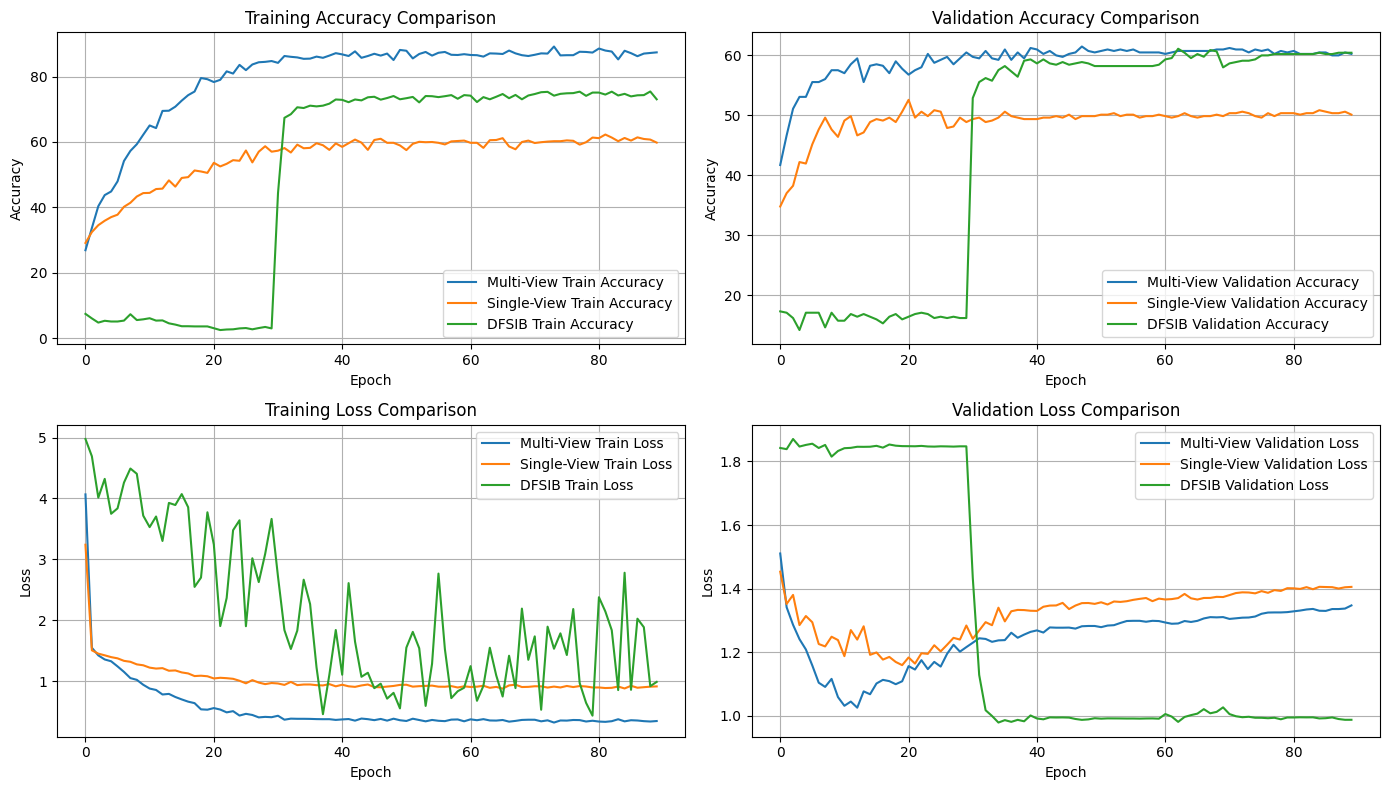

In [3]:
#image

import pickle
import matplotlib.pyplot as plt
import os

def load_history(file_path):
    # Load training history from a pickle file
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def plot_combined_histories(model_dir, filenames, labels):
    # Load and plot combined histories for training and validation metrics
    histories = {}
    for filename, label in zip(filenames, labels):
        history_path = os.path.join(model_dir, filename)
        histories[label] = load_history(history_path)

    plt.figure(figsize=(14, 8))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for label in labels:
        plt.plot(histories[label]['train_accuracy'], label=f'{label} Train Accuracy')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(2, 2, 2)
    for label in labels:
        plt.plot(histories[label]['validation_accuracy'], label=f'{label} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot training loss (single axis plot)
    plt.subplot(2, 2, 3)
    for label in labels:
        plt.plot(histories[label]['train_loss'], label=f'{label} Train Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot validation loss (single axis plot)
    plt.subplot(2, 2, 4)
    for label in labels:
        plt.plot(histories[label]['validation_loss'], label=f'{label} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'final_combined_history_comparison_single_axis.png'))
    plt.show()

if __name__ == '__main__':
    model_dir = 'final/image'
    filenames = [
        'multi_view_history_standardized_converted.pkl',
        'single_view_history_standardized_converted.pkl',
        'combined_training_history_standardized.pkl'
    ]
    labels = ['Multi-View', 'Single-View', 'DFSIB']
    plot_combined_histories(model_dir, filenames, labels)


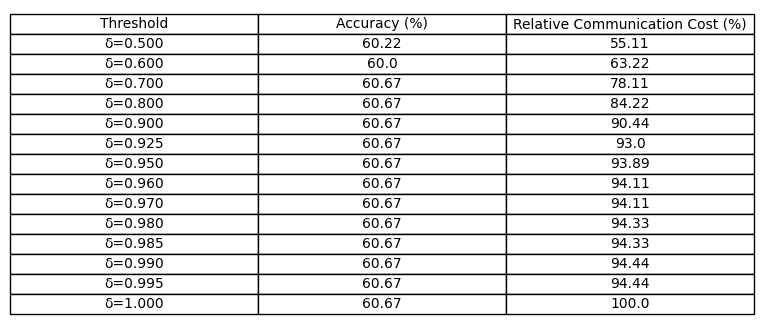

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    "Threshold": [
        "δ=0.500", "δ=0.600", "δ=0.700",
        "δ=0.800", "δ=0.900", "δ=0.925",
        "δ=0.950", "δ=0.960", "δ=0.970",
        "δ=0.980", "δ=0.985", "δ=0.990",
        "δ=0.995", "δ=1.000"
    ],
    "Accuracy (%)": [60.22, 60.0, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67, 60.67],
    "Relative Communication Cost (%)": [9.92/18.0, 11.38/18.0, 14.06/18.0, 15.16/18.0, 16.28/18.0,
                                         16.74/18.0, 16.9/18.0, 16.94/18.0, 16.94/18.0, 16.98/18.0,
                                         16.98/18.0, 17.0/18.0, 17.0/18.0, 18.0/18.0]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert the relative communication cost to percentage and round to two decimal places
df["Relative Communication Cost (%)"] = (df["Relative Communication Cost (%)"] * 100).round(2)

# Draw the table
plt.figure(figsize=(8, 4))
plt.axis('off')
table = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the table as an image
plt.savefig('relative_communication_cost_table_adjusted.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set font size
sns.set(font_scale=2)  # Increase font size by adjusting font_scale

# Load the predicted and true labels
base_dir = 'final/confusion'
files = {
    "Single View": ("single_view_labels_test_true.npy", "single_view_labels_test_pred.npy"),
    "Multi View": ("multi_view_labels_test_true.npy", "multi_view_labels_test_pred.npy"),
    "DFSIB": ("multi_view_fine_tune_labels_test_true.npy", "multi_view_fine_tune_labels_test_pred.npy")
}

# Generate confusion matrices
for key, (true_file, pred_file) in files.items():
    true_labels = np.load(f'{base_dir}/{true_file}')
    pred_labels = np.load(f'{base_dir}/{pred_file}')

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(f'{key} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Save confusion matrix image
    plt.savefig(f'{base_dir}/{key.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.close()
